In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_json(file_name, data_size=None, name=None):
    # Read the JSON file
    with open(file_name, 'r') as f:
        data = json.load(f)

    # Extract values
    times = [t * 1000 for t in data["time"]]  # ms

    retrival_f1 = data["re_f1"]
    retrival_recall = data["re_recal"]

    if data_size is not None:
        data["data_size"] = data_size

    data_sizes = data["data_size"]  # bytes

    # Compute the required values
    results1 = [ds / t * f1 for ds, t, f1 in zip(data_sizes, times, retrival_f1)]
    results2 = [ds / t * f1 for ds, t, f1 in zip(data_sizes, times, retrival_recall)]
    # Add result and file_name to the data dictionary
    data["results1"] = results1
    data["results2"] = results2
    if name is not None:
        data["name"] = name
    else:
        data["name"] = file_name

    return data

def plot_multiple_boxplots_dev(data_lists, items):
    """
    绘制多个数据集的 boxplot，并标注均值、标准差、分位点，并添加图例。
    
    参数:
        data_lists (list of list): 包含多个数据集列表，每个列表包含多个数据字典，每个字典结构如下：
                                   {"file_name": ..., "results": [...], ...}
        items (list): 需要绘制的指标名称，每个 item 代表一个子图。
    """
    plt.style.use('bmh')
    num_items = len(items)
    num_lists = len(data_lists)
    fig, axes = plt.subplots(num_lists, num_items, figsize=( 6 * num_items,6 * num_lists), dpi=500)
    
    if num_items == 1 and num_lists == 1:
        axes = [axes]  # 保证 axes 可迭代
    elif num_items == 1:
        axes = axes[:, np.newaxis]  # 调整维度
    elif num_lists == 1:
        axes = axes[np.newaxis, :]  # 调整维度
        
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    label_index = 0
    
    for i, data_list in enumerate(data_lists):
        for j, item in enumerate(items):
            ax = axes[i, j]
            all_results = []
            labels = []
            
            # 遍历所有数据集
            for data in data_list:
                results = np.array(data[item])
                
                # 计算 IQR（四分位距）
                q1, q3 = np.percentile(results, [25, 75])
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # 去除离群点
                filtered_results = results[(results >= lower_bound) & (results <= upper_bound)]
                
                all_results.append(filtered_results)
                labels.append(data["name"].split("/")[-1].split(".")[0])  # 仅取文件名（无路径 & 扩展名）
            
            if item == "time":
                item_name = "Retrieval Time (s)"
            elif item == "re_f1":
                item_name = "Retrieval Accuracy"
            elif item == "results1":
                item_name = "Retrieval Efficiency (byte/ms)"
            else:
                item_name = item
            
            # 画出 BoxPlot
            sns.boxplot(data=all_results, ax=ax, width=0.5, palette=['#cadcff', '#99c2e6', '#4995e4']) # ['#cadcff', '#99c2e6', '#59a5d4']
            
            # 标注统计信息
            legend_handles = []
            for k, results in enumerate(all_results):
                mean_val = np.mean(results)
                std_val = np.std(results)
                q1, q2, q3 = np.percentile(results, [25, 50, 75])  # 计算 25%、50%、75% 分位点
                
                # 均值线
                mean_line, = ax.plot([k - 0.25, k + 0.25], [mean_val, mean_val], color='red', linestyle='--', linewidth=1.5)
                # 标准差
                std_line, = ax.plot([k - 0.2, k + 0.2], [mean_val + std_val, mean_val + std_val], color='slategray', linestyle='-', linewidth=1.2)
                std_line, = ax.plot([k - 0.2, k + 0.2], [mean_val - std_val, mean_val - std_val], color='slategray', linestyle='-', linewidth=1.2)
                # 中位数
                median_line, = ax.plot([k - 0.2, k + 0.2], [q2, q2], color='steelblue', linestyle='-', linewidth=1.5)
                # Q1, Q3
                q1_line, = ax.plot([k - 0.2, k + 0.2], [q1, q1], color='darkolivegreen', linestyle=':', linewidth=1.2)
                q3_line, = ax.plot([k - 0.2, k + 0.2], [q3, q3], color='darkolivegreen', linestyle=':', linewidth=1.2)
                
                # 在图上显示均值
                ax.text(k, mean_val, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=14, color='red')
                
                # 仅在第一个数据集时添加图例
                if k == 0:
                    legend_handles.extend([mean_line, std_line, median_line, q1_line, q3_line])
            
            # 设置轴标签
            ax.set_xticklabels(labels, fontsize=14, rotation=0)
            ax.set_ylabel(item_name, fontsize=16)
            ax.text(0.0, 1.01, f"({alphabet[label_index]})", transform=ax.transAxes, fontsize=18, va='bottom', ha='center') #fontweight='bold'
            # ax.set_title(f" ({alphabet[label_index]})", fontsize=14, va = 'bottom')
            label_index += 1
            
            # 添加图例
            ax.legend(legend_handles, ['Mean', 'Mean ± 1σ', 'Median (Q2)', 'Q1 (25%)', 'Q3 (75%)'], fontsize=10, loc='upper right')
            
            # 显示网格
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        if i == 0:
            axes[i, 0].set_title(f" ", fontsize=40)
            fig.text(0.5, (num_lists - i - 0.05 ) / num_lists, "Boxplot Analysis on English Dataset (HotpotQA)", ha='center', fontsize=18, fontweight='bold')
        else:
            axes[i, 0].set_title(f" ", fontsize=50)
            fig.text(0.5, (num_lists - i - 0.05 ) / num_lists, "Boxplot Analysis on Chinese Dataset (RGB zh)", ha='center', fontsize=18, fontweight='bold')

    # 防止图表布局溢出
    plt.tight_layout()
    plt.show()

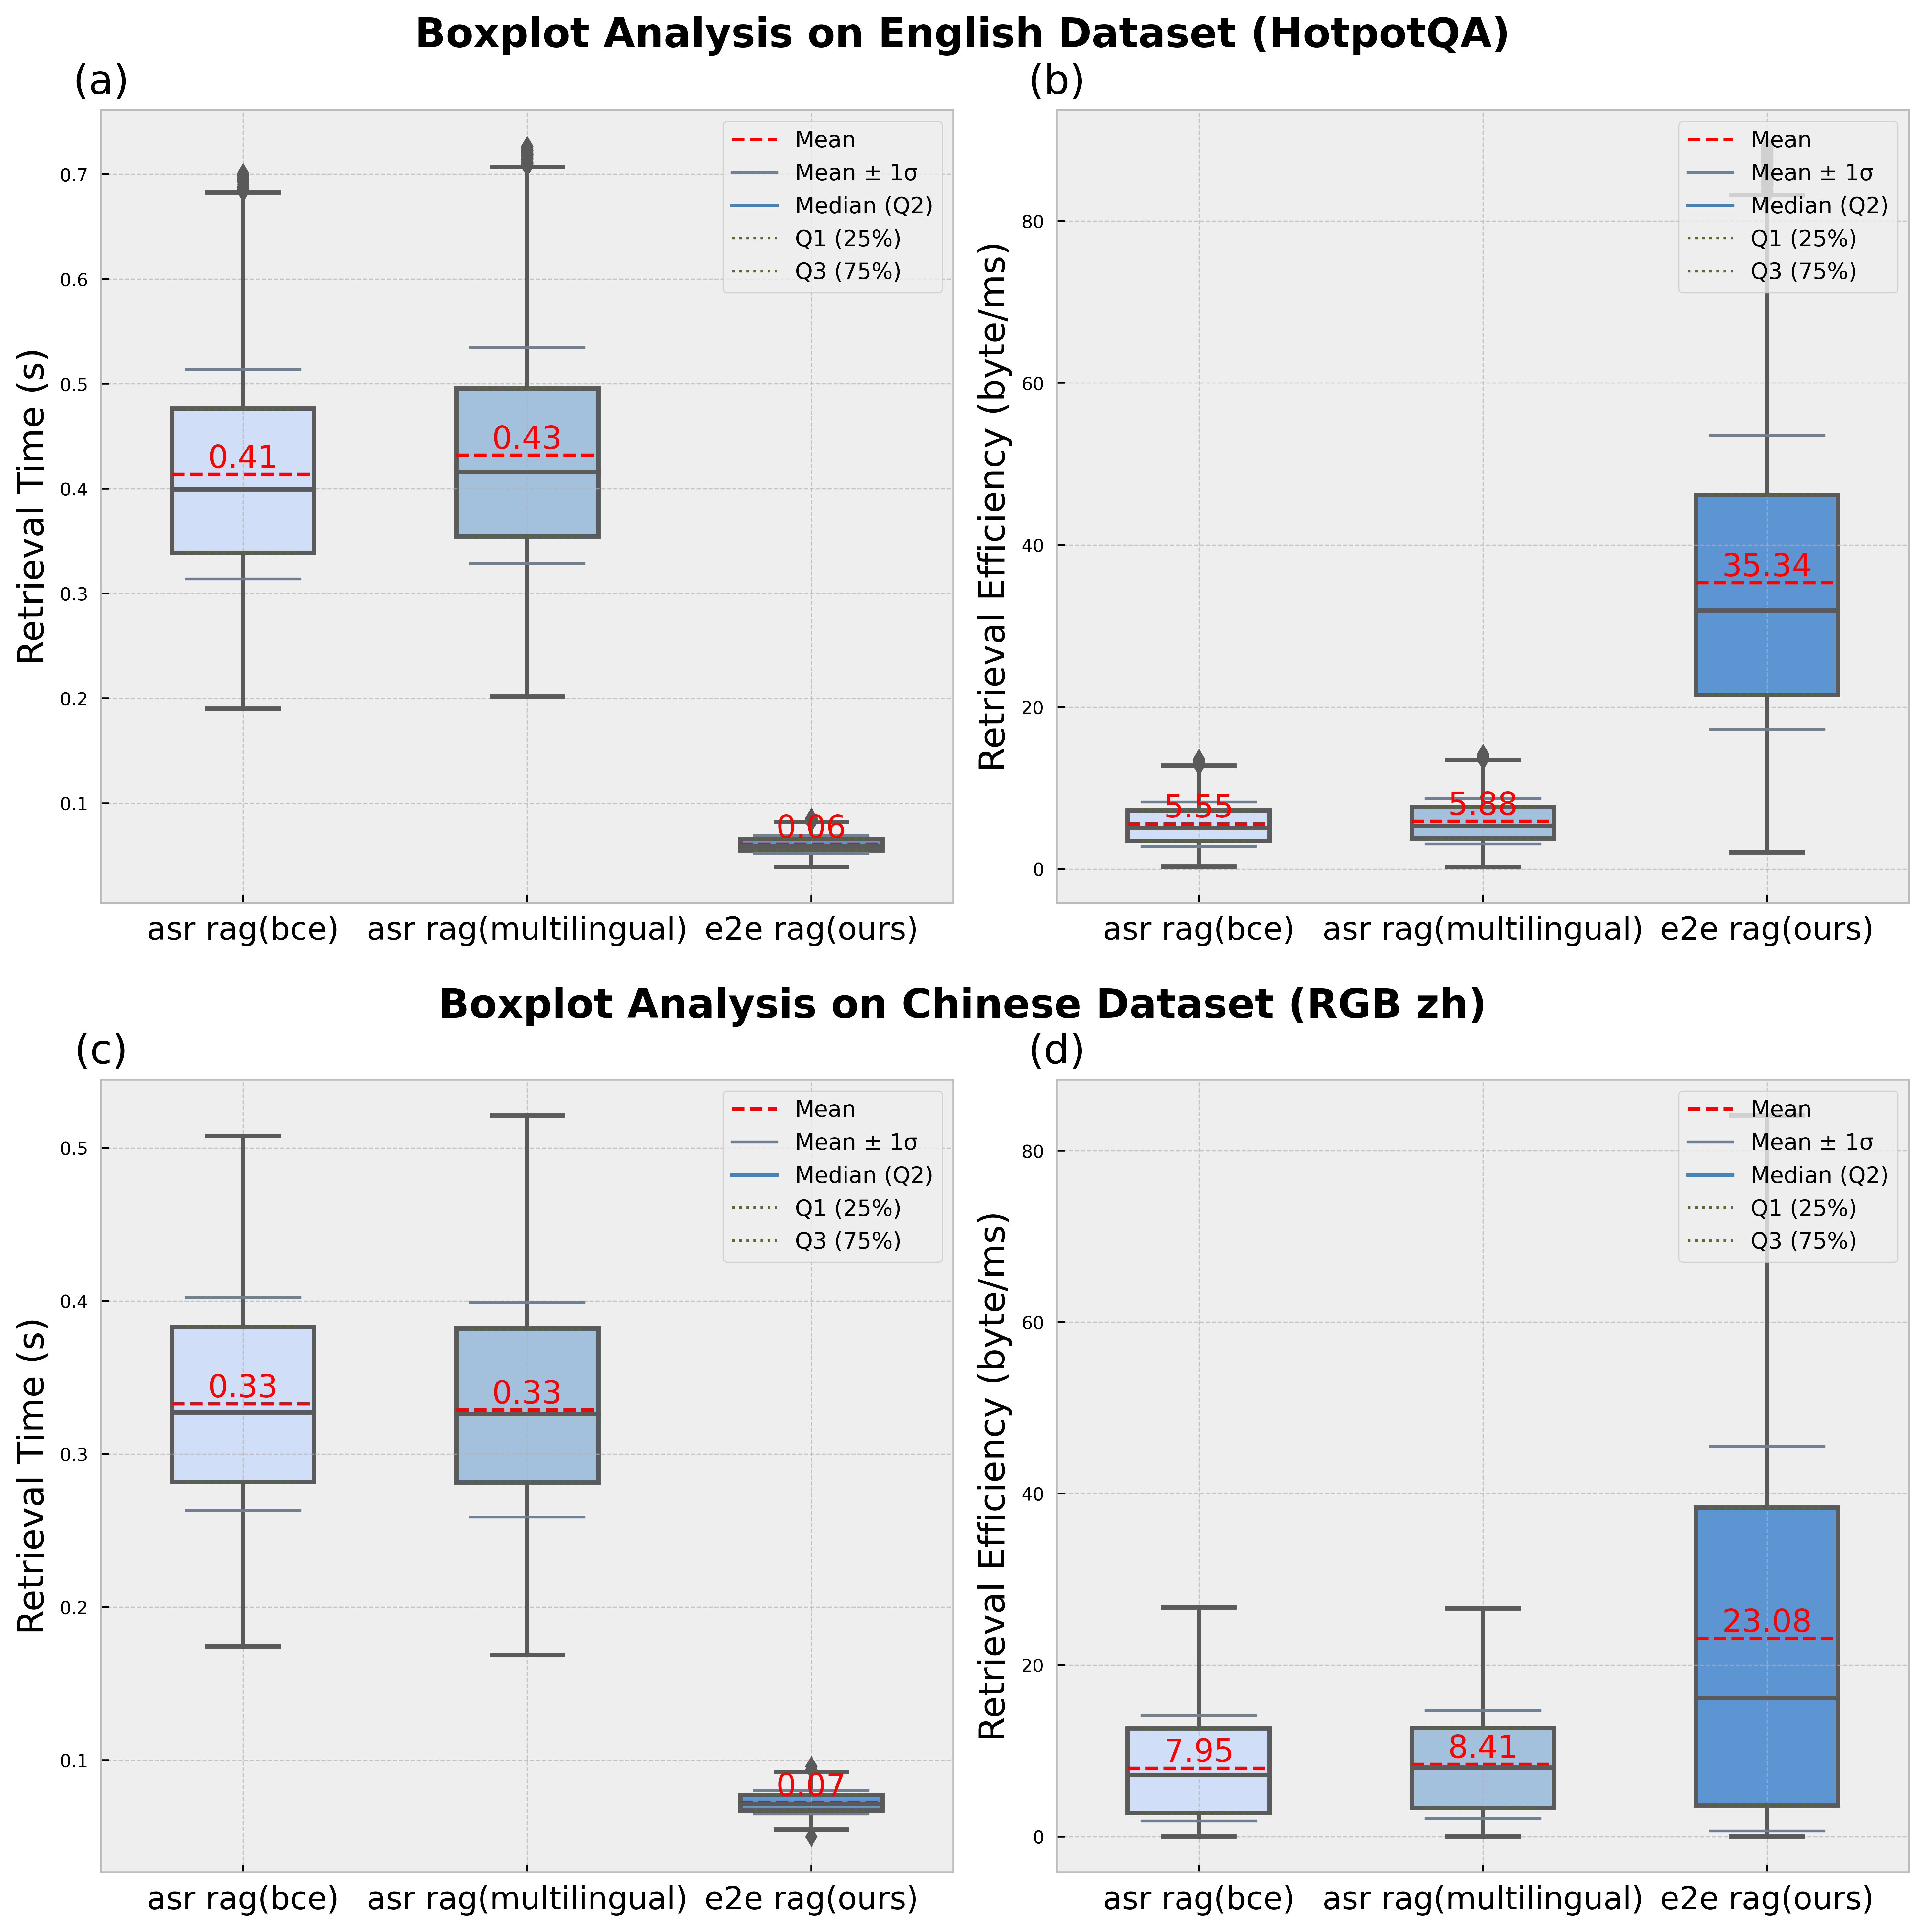

In [ ]:
dataa1 = read_json("data_asr_bce.json", name="asr rag(bce)")
dataa2 = read_json("data_asr_multi.json", name="asr rag(multilingual)")
datae3 = read_json("data_time.json", name="e2e rag(ours)")

data1 = read_json("bce-asr.json",name="asr rag(bce)")
data2 = read_json("multi-asr.json", name="asr rag(multilingual)")
data3 = read_json("sonar_zh.json",name="e2e rag(ours)")

plot_multiple_boxplots_dev([[dataa1, dataa2, datae3] , [data1, data2, data3]], items=["time","results1"])